In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%pylab inline
import seaborn as sns
import xgboost
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Populating the interactive namespace from numpy and matplotlib
/kaggle/input/heart-disease-uci/heart.csv


## Heart disease dataset - exploration

In [2]:
heart_dataset = pd.read_csv("/kaggle/input/heart-disease-uci/heart.csv")

In [3]:
heart_dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


#### Description of columns from the text file

* age - age
* sex - biological sex (1 = male, 0 = female)
* cp - chest pain type
  * Value 1: typical angina
  * Value 2: atypical angina
  * Value 3: non-anginal pain
  * Value 4: asymptomatic
* trestbps - resting blood pressure on admission to hospital
* chol - serum cholesterol (mg/dl)
* fbs - fasting blood sugar (indicator variable, 1 if > 120 mg/dl, 0 o.w)
* restecg - resting electrocardiographic results
  * Value 0: normal
  * Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
  * Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
                    
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope: the slope of the peak exercise ST segment
  * Value 1: upsloping
  * Value 2: flat
  * Value 3: downsloping
* ca - number of major vessels colored by fluroscopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
*  target - diagnosis of heart disease (angiographic disease status)
   * Value 0: < 50% diameter narrowing
   * Value 1: > 50% diameter narrowing





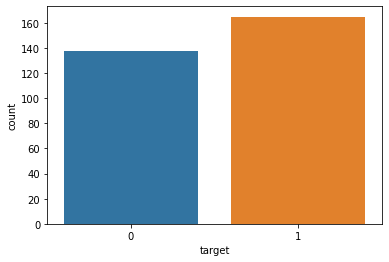

In [4]:
sns.countplot(x = "target", data = heart_dataset)

There seems to exist a slight class imbalance. We might need to accommodate this if required

## Exploring specific columns

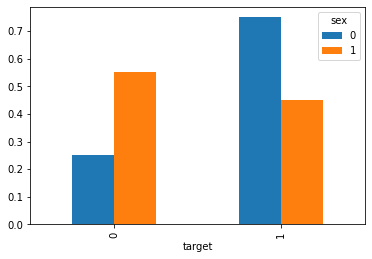

In [5]:
splitBySex = pd.crosstab(heart_dataset["target"], heart_dataset["sex"])
splitBySex[1] /= sum(splitBySex[1])
splitBySex[0] /= sum(splitBySex[0])
splitBySex.plot(kind = "bar")

If you have a heart failure, there seems to be a greater chance that you're female, i.e., P(female | diseased person) > P(male | diseased person)

The other probability also (for completion)

In [6]:
sexSplitByDisease = pd.crosstab(heart_dataset["sex"], heart_dataset["target"])
sexSplitByDisease[0] /= sum(sexSplitByDisease[0])
sexSplitByDisease[1] /= sum(sexSplitByDisease[1])

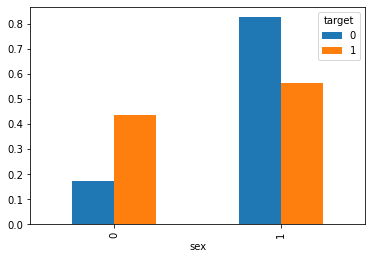

In [7]:
sexSplitByDisease.plot(kind = "bar")

If you're female there's a greater chance that you're diseased i.e., P(diseased | female) > P(diseased | male)

In [8]:
positives = heart_dataset.loc[heart_dataset["target"] == 1]
negatives = heart_dataset.loc[heart_dataset["target"] == 0]

### Age group

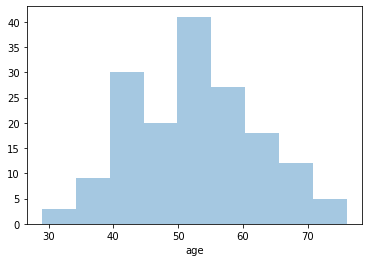

In [9]:
sns.distplot(positives["age"],kde = False)

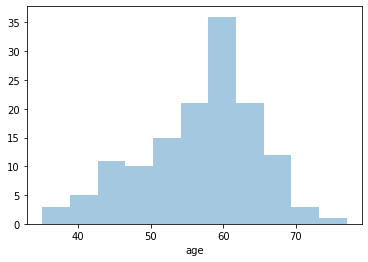

In [10]:
sns.distplot(negatives["age"],kde = False)

The bi-modality in the positives is quite striking, as is the peak in the 60s for the negatives. Looks like old people are healthy after all :) 

### Angina - cp

Angina - A type of chest pain caused by reduced blood flow to the heart. Let's check the correlation of cp with heart failure rates, given that heart failure criteria is given as narrowing of artery diameter (which could cause angina, hence angina being the predictor)

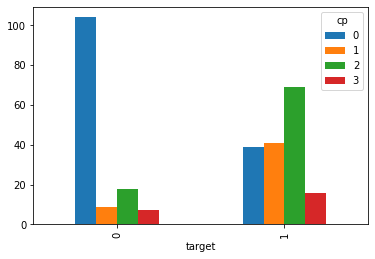

In [11]:
pd.crosstab(heart_dataset["target"], heart_dataset["cp"]).plot(kind = "bar")

Recall
* Value 0: typical angina
* Value 1: atypical angina
* Value 2: non-anginal pain
* Value 3: asymptomatic

Looks like non-anginal pain seems to be a marker for heart failure, while anginal pain seems to be a marker for no heart failure

#### trestbps - Resting blood pressure

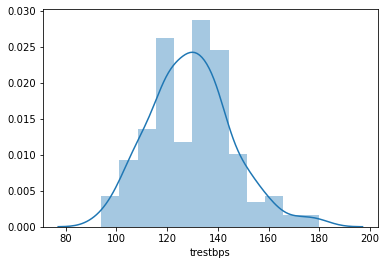

In [12]:
sns.distplot(positives["trestbps"])

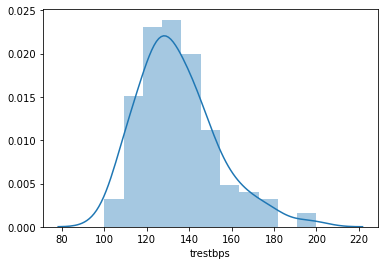

In [13]:
sns.distplot(negatives["trestbps"])

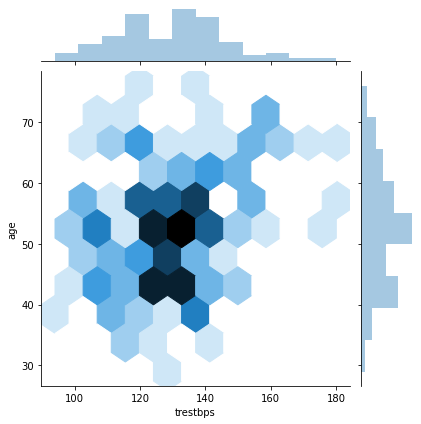

In [14]:
sns.jointplot(x = positives["trestbps"], y = positives["age"],kind = "hex")

Looks like most people having heart failures seem to be in their 50s and having moderately high (130 mm Hg) blood pressure

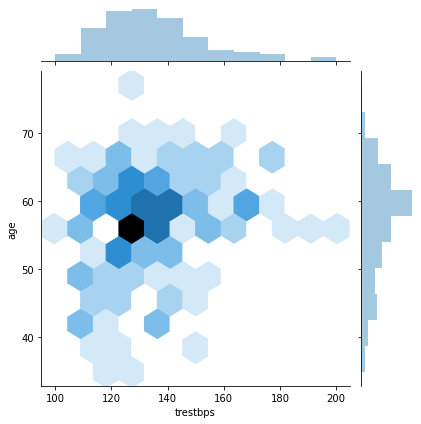

In [15]:
sns.jointplot(x = negatives["trestbps"], y = negatives["age"], kind = "hex")

The highest distribution here too seems to be on the lower side (120s) and in the same age group as above (50s)

#### ca - Number of major vessels coloured by fluoroscopy

What I understand from [here](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/fluoroscopy-procedure) and [here](https://www.hopkinsmedicine.org/health/treatment-tests-and-therapies/cardiac-catheterization) is that a tube is inserted and the arteries coloured to check for any blockages. So I'm assuming the more vessels that were checked, the stronger our conclusions are, so the `ca` variable could be a very strong predictor of the presence or absence of the disease

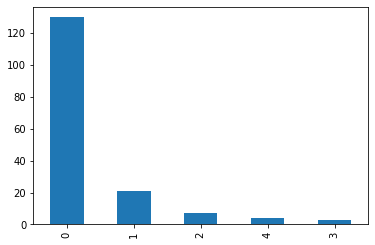

In [16]:
(positives["ca"].value_counts()).plot(kind = "bar")

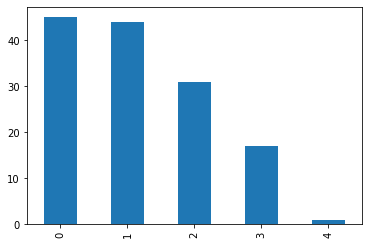

In [17]:
negatives["ca"].value_counts().plot(kind = "bar")

So this means if a fluoroscopy is done, there is a greater chance of not having a heart failure. For the time being, we will include `ca` as a bool - ca > 0 : 1, else 0

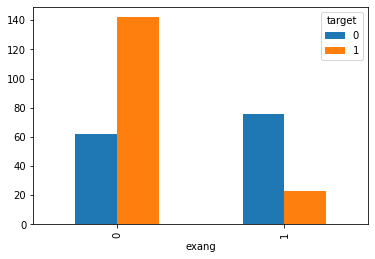

In [18]:
pd.crosstab(heart_dataset["exang"],heart_dataset["target"]).plot(kind = "bar")

Exercise induced angina seems to be a negative indicator of heart failure

#### Oldpeak and thal

Since I'm no doctor, I don't have an intuitive idea of what these are supposed to mean and how the slope affects diagnosis, so I plot these without any intuition

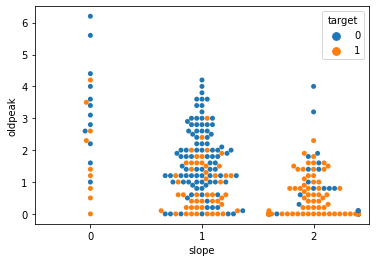

In [19]:
sns.swarmplot(y = heart_dataset["oldpeak"], x = heart_dataset["slope"], hue = heart_dataset["target"])

slope 2 and low oldpeak seems to be clear cut indicators of heart failure. High values of olepeak seems to be correlated with no heart failure. So we expect similar results in the model. We will one-hot encode slope

#### chol - Serum cholesterol

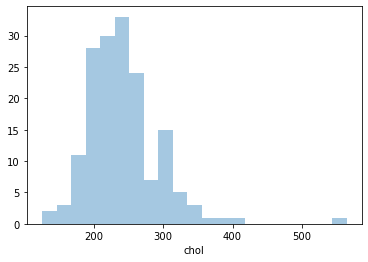

In [20]:
sns.distplot(positives["chol"], kde = False)

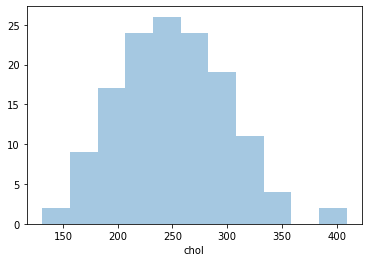

In [21]:
sns.distplot(negatives["chol"], kde = False)

This doesn't look like a very important variable, given that the core regions of positives and negatives overlap

To summarize, we shall be doing the following for modelling

* Age - as is, no normalization
* Sex - as is, no modifications
* cp - one hot encode
* fbs - as is, no modification
* restecg - one hot encode
* trestbps, chol, thalach, oldpeak - Normalize using StandardScaler so that the numbers that enter the model have the same order of magnitude
* exang - include (expect negative correlation)
* slope - on ehot encode
* ca - make it bool ( 1 if at least one vesse coloured by fluoroscopy)
* thal - drop (because I don't know what this variable is)

## ML Models

### Logistic Regression

Let's start with good ol' logistic regression, because we'll be able to understand the individual coefficients in a linear model[](http://)


In [22]:
from  sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

#### Create X and Y arrays for ML

Let's check how the data is distributed in the dataset - we don't want all positive and all negative targets together

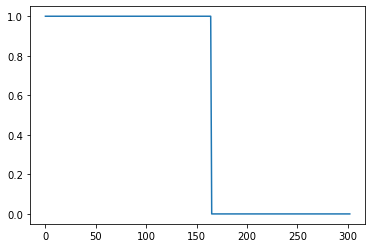

In [23]:
plt.plot(heart_dataset["target"])

Yep, we need to shuffle the dataset

In [24]:
X = heart_dataset.sample(frac=1) #shuffle shuffle shuffle
X = X.drop(["thal"], axis = 1)

In [25]:
#Insert the ca boolean variable in place of the ca variable
X["cabool"] = X["ca"].apply(lambda x : 1 if x > 0 else 0)
X = X.drop(["ca"], axis = 1)
X["ca"] = X["cabool"]
X = X.drop(["cabool"], axis = 1)

In [26]:
#copy the targets to y
y = X["target"].copy()
X = X.drop(["target"], axis = 1)

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split

In [28]:
#Using pipelines to do everything together - makes life easy
onehot_encoder = OneHotEncoder(handle_unknown = "ignore", sparse = False)
numerical_scaler = StandardScaler()
preprocessor = ColumnTransformer(transformers = [("numerical_scaler",numerical_scaler,["trestbps","chol","thalach","oldpeak"]),("onehot_encoder",onehot_encoder,["cp","restecg","slope"])], remainder = "passthrough")


In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X,y,train_size = 0.8)

In [30]:
from sklearn.linear_model import LogisticRegression
fit_model = LogisticRegression(max_iter = 1000, C = 0.5, class_weight = "balanced")
lr_pipeline = Pipeline(steps = [("preprocessor",preprocessor),("model",fit_model)])

We will do a grid search to find the best logistic regression regularization parameter

In [31]:
from sklearn.model_selection import GridSearchCV
param_grid = {"model__C" : np.logspace(-5,0,10)}
search = GridSearchCV(lr_pipeline, param_grid, n_jobs = -1)
search.fit(X_train,y_train)


GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_scaler',
                                                                         StandardScaler(),
                                                                         ['trestbps',
                                                                          'chol',
                                                                          'thalach',
                                                                          'oldpeak']),
                                                                        ('onehot_encoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                

In [32]:
search.best_score_

0.8556122448979592

In [33]:
search.best_params_

{'model__C': 1.0}

In [34]:
#Redefine the pipeline with the best C
fit_model = LogisticRegression(max_iter = 1000, C = search.best_params_["model__C"], class_weight = "balanced")
lr_pipeline = Pipeline(steps = [("preprocessor",preprocessor),("model",fit_model)])

In [35]:
lr_pipeline.fit(X_train,y_train)
lr_preds = lr_pipeline.predict(X_valid)
print("Accuracy = ",sum(lr_preds == y_valid)/len(y_valid))

Accuracy =  0.8032786885245902


Time for some metrics

In [36]:
from sklearn.metrics import confusion_matrix,f1_score
lr_CM = confusion_matrix(y_valid, lr_preds)
lr_TP = lr_CM[1,1]
lr_TN = lr_CM[0,0]
lr_FP = lr_CM[0,1]
lr_FN = lr_CM[1,0]
print(lr_CM)

[[20  7]
 [ 5 29]]


Confusion matrix order :- 

TN | FP  
FN | TP

In [37]:
lr_recall = lr_TP/(lr_TP + lr_FN)
lr_specificity = lr_TN/(lr_TN + lr_FP)
lr_precision = lr_TP/(lr_TP + lr_FP)

print(lr_recall,lr_specificity)

0.8529411764705882 0.7407407407407407


Our model seems to have decent recall and specificity

In [38]:
lr_f1_score = f1_score(y_valid, lr_preds)
lr_f1_score

0.8285714285714286

In [39]:
#Prep for ROC score curves
from sklearn.metrics import roc_curve, roc_auc_score
lr_y_proba = lr_pipeline.predict_proba(X_valid)[:,1]
lr_fpr,lr_tpr,lr_threshold = roc_curve(y_valid,lr_y_proba)

#### A look at the coefficients

column names in X_train : trestbps, chol, thalach, oldpeak, cp = 0, cp = 1, cp = 2, cp = 3, restecg = 0, restecg = 1, restecg = 2, slope = 0, slope = 1, slope = 2, age, sex, fbs, exang, ca. The fit gives us weights in the same order

In [40]:
fit_model.coef_, fit_model.intercept_

(array([[-0.32489363, -0.51836083,  0.50595553, -0.54350066, -1.24096156,
          0.27192936,  0.3636651 ,  0.61072   ,  0.02176843,  0.0427218 ,
         -0.05913733,  0.09875905, -0.5500658 ,  0.45665965,  0.01952289,
         -1.62837041,  0.05153283, -0.77409338, -1.80103431]]),
 array([1.4570793]))

Some of our conclusions from the visualization part seem to have come true

* `ca` is a very good predictor of not having a heart disease (in fact the best predictor)
* `exang` being moderately negatively correlated with heart disease
* `sex` being negatively correlated (women being more prone than men)
* `slope` = 2 being a good indicator (moderately high positive weight)
* `cp` = 2 (non-anginal pain) having the highest positive weight

Overall, this has confirmed some of the trends we saw in the visualization phase

### Random forests


In [41]:
from sklearn.ensemble import RandomForestClassifier

In [42]:
rf_model = RandomForestClassifier(n_estimators = 1000)
rf_pipeline = Pipeline([("preprocessor",preprocessor),("model",rf_model)])

In [43]:
rf_search = GridSearchCV(rf_pipeline,param_grid = {"model__n_estimators":np.arange(100,1100,100)},n_jobs = -1)
rf_search.fit(X_train,y_train)

GridSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('numerical_scaler',
                                                                         StandardScaler(),
                                                                         ['trestbps',
                                                                          'chol',
                                                                          'thalach',
                                                                          'oldpeak']),
                                                                        ('onehot_encoder',
                                                                         OneHotEncoder(handle_unknown='ignore',
                                                                                       sparse=False),
                                

In [44]:
rf_search.best_params_

{'model__n_estimators': 100}

In [45]:
rf_search.best_score_

0.822278911564626

In [46]:
rf_model = RandomForestClassifier(n_estimators = rf_search.best_params_["model__n_estimators"])
rf_pipeline = Pipeline([("preprocessor",preprocessor),("model",rf_model)])
rf_pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('numerical_scaler',
                                                  StandardScaler(),
                                                  ['trestbps', 'chol',
                                                   'thalach', 'oldpeak']),
                                                 ('onehot_encoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['cp', 'restecg',
                                                   'slope'])])),
                ('model', RandomForestClassifier())])

In [47]:
rf_preds = rf_pipeline.predict(X_valid)
print(sum(rf_preds == y_valid)/len(rf_preds))

0.8360655737704918


In [48]:
all(rf_preds == lr_preds) #Confirmation in case the accuracies turn out to be equal

False

In [49]:
rf_CM = confusion_matrix(y_valid, rf_preds)
rf_TP = rf_CM[1,1]
rf_TN = rf_CM[0,0]
rf_FP = rf_CM[0,1]
rf_FN = rf_CM[1,0]
print(rf_CM)

[[20  7]
 [ 3 31]]


In [50]:
rf_recall = rf_TP/(rf_TP + rf_FN)
rf_specificity = rf_TN/(rf_TN + rf_FP)
lr_precision = rf_TP/(rf_TP + rf_FP)

print(rf_recall,rf_specificity)

0.9117647058823529 0.7407407407407407


In [51]:
print(lr_recall, lr_specificity)

0.8529411764705882 0.7407407407407407


the random forest model seems to give us a better recall sacrificing specifity. We need a very good recall rate so that we have low false negatives in our diagnosis

In [52]:
rf_y_proba = rf_pipeline.predict_proba(X_valid)[:,1]
rf_fpr,rf_tpr,rf_threshold = roc_curve(y_valid,rf_y_proba)

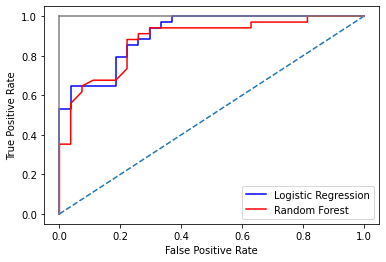

In [53]:
plt.plot(lr_fpr,lr_tpr,"b", label = "Logistic Regression")
plt.plot(rf_fpr, rf_tpr, "r", label = "Random Forest")
plt.plot([0,1],ls = "--")
plt.plot([0,0],[1,0],c='.5')
plt.plot([1,1],c='.5')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

In [54]:
print("logistic regression AUC = ",roc_auc_score(y_valid,lr_preds))
print("Random forests AUC = ",roc_auc_score(y_valid,rf_preds))

logistic regression AUC =  0.7968409586056645
Random forests AUC =  0.8262527233115468


Logistic Regression seems to have a slight edge in the AUC score